In [20]:
%load_ext autoreload
%autoreload 2
import math
import sys
import os

import uproot
import numpy as np
import pandas as pd
import awkward as ak

import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("../..")
from hists.parameters import synchrotronBeamEnergiesMap, beamEnergies
from ratios_utils import makeFrequencyPerBeamEnergy
from HistogramLib.store import HistogramStore
from hists.store import HistogramId

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v38'
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}
datatypes = ["data", "sim_proton_v46_patchMIP"]

def loadTree(datatype):
    path = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root:clusters")
    tree = uproot.open(path)
    return tree

In [22]:
def findEventsWithSmallMainTrackster(tree, sizeThreshold=20, energyFractionThreshold=0.7, stopAfter=math.inf):
    """ Find events where the main trackster size is less than sizeThreshold
    """
    filtered_arrays = []
    count = 0
    for array in tree.iterate(step_size="100MB", library="ak", 
            filter_name=["event", "ntupleNumber", "beamEnergy", "rechits_energy", "clus3D_size"]):
        cut = ak.max(array.clus3D_size, axis=-1) < sizeThreshold
        cut = cut & (ak.sum(array.rechits_energy, axis=-1)<array.beamEnergy*energyFractionThreshold)
        filtered_arrays.append(ak.copy(array[cut]))
        count += np.sum(cut)
        if count > stopAfter:
            break
    return ak.drop_none(ak.concatenate(filtered_arrays))

In [24]:
smallTracksterEvents = {datatype : findEventsWithSmallMainTrackster(loadTree(datatype), 15) for datatype in datatypes}
smallTracksterEvents

{'data': <Array [{beamEnergy: 20, ...}, ..., {...}] type='15 * {beamEnergy: float32,...'>,
 'sim_proton_v46_patchMIP': <Array [{beamEnergy: 100, ...}, ..., {...}] type='458 * {beamEnergy: float3...'>}

In [25]:
smallTracksterEvents["sim_proton_v46_patchMIP"]

<Array [{beamEnergy: 100, ...}, ..., {...}] type='458 * {beamEnergy: float3...'>

In [26]:
def plotFrequencyPerBeamEnergy(series_dict:dict[str, pd.Series], settings:dict=dict(), ax=None, alternative_hypothesis="two-sided", datatypeToLegendMap={"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}):
    """ Plot the frequency of occurence per beam energy, given a set of beam energy values to histogram
    Parameters : 
     - series : datatype -> (series of beam energies to histogram)
     - settings : dict to plot on top right
     - alternative_hypothesis : two-sided or greater 
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    errorbar_kwargs = dict()
    if alternative_hypothesis == "greater":
        errorbar_kwargs["lolims"] = True

    offset_x = 3
    cur_offset = 0
    for datatype, series in series_dict.items():
        ratio_val, ratio_errors = makeFrequencyPerBeamEnergy(histStore, clueParams, series, datatype)
        ax.errorbar(x=np.array(beamEnergies)+cur_offset, y=ratio_val, yerr=ratio_errors, fmt="o-", #ecolor="black", 
                     label=datatypeToLegendMap.get(datatype, datatype), **errorbar_kwargs)
        cur_offset += offset_x

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Fraction of small-main-trackster events")
    hep.cms.text("Preliminary", ax=ax)
    hep.cms.lumitext(" ".join([f"{key}={val}" for key, val in settings.items()]) + " $e^+$ TB", ax=ax, fontsize=15)
    ax.legend()
    return fig, ax
    #return ratio_val, ratio_errors

FileNotFoundError: [Errno 2] No such file or directory: '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v38/cmssw/data/EventsPerBeamEnergy.pickle'

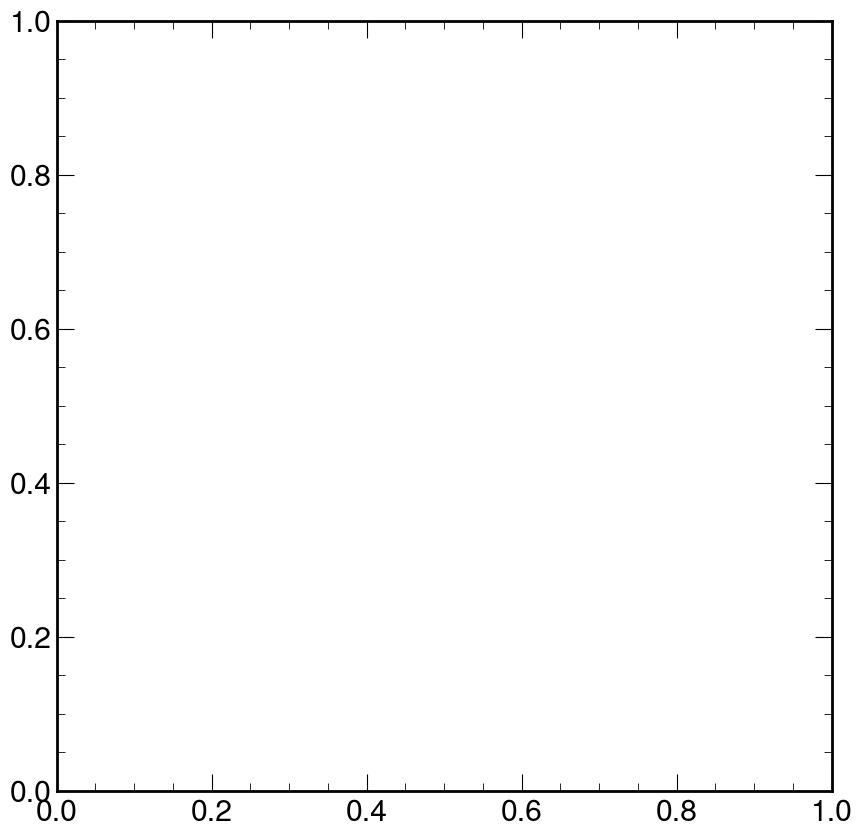

In [27]:
plotFrequencyPerBeamEnergy({datatype : tree.beamEnergy for datatype, tree in smallTracksterEvents.items()})